In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

#### Quadrant Model

Given NWP data, for each init_time and forecast horizon, downsample the geospatial grid into 4 quadrants (2x2 grid per channel). This extends our feature space from 23 variables (17+6) to 74 (4*17 + 6).

In [2]:
from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple

nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)


TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]

def _get_path_to_quadrant_data(forecast_horizon: int) -> str:
    return f"/home/tom/local_data/geospatial_dsample_processed_nwp_data_step_{forecast_horizon}.npy"


def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:init_time=30,
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )



def build_datasets_from_local(step: int, nan_to_zero: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = np.load(_get_path_to_quadrant_data(step))
    X = X.reshape(X.shape[2], X.shape[1]*4)
    X =  np.nan_to_num(X) if nan_to_zero else X
    
    
    columns = []
    for var in nwp.coords["variable"].values:
        columns += [f"{var}_{x}" for x in range(1, 5)]
    
    X = pd.DataFrame(data=X, columns = columns, index=evaluation_timeseries)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by the step forecast
    shift = nwp.step.values[step]
    y = y.shift(freq=-shift).dropna()
    common_index=sorted(pd.DatetimeIndex((set(y.index).intersection(X.index))))
    
    X, y = X.loc[common_index], y.loc[common_index]
    
    # add datetime methods for the point at which we are forecasting e.g. now + step
    _X = trigonometric_datetime_transformation(y.shift(freq=nwp.step.values[step]).index.values)
    _X = pd.DataFrame(_X, index=y.index, columns=TRIG_DATETIME_FEATURE_NAMES)
    X = pd.concat([X, _X], axis=1)
    
    # add lagged values of GSP PV
    ar_1 = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    ar_day = y.shift(freq = - (shift + np.timedelta64(1, "D")))
    ar_1.columns = ["PV_LAG_1HR"]
    ar_day.columns = ["PV_LAG_DAY"]
    
    # estimate linear trend of the PV
    window_size = 10
    epsilon = 0.01
    y_covariates = y.shift(freq = -(shift + np.timedelta64(2, "h")))
    y_covariates.columns = ["x"]
    y_target = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    y_target.columns = ["y"]
    data = pd.concat([y_target, y_covariates], axis=1).dropna()
    _x = data["x"].values
    _y = data["y"].values
    _betas = np.nan * np.empty(len(data))
    
    for n in range(window_size, len(data)):
        __y = _y[(n-window_size): n]
        __x = _x[(n-window_size): n]
        __b = max(min((1 / ((__x.T @ __x) + epsilon))  * (__x.T @ __y), 10), -10)
        _betas[n] = __b
    
    betas = pd.DataFrame(data=_betas, columns=["AR_Beta"], index=data.index)
    
    X = pd.concat([X, ar_1, ar_day, betas], axis=1).dropna()
    y = y.loc[X.index]
    
    
    return X, y

In [3]:
X, y = build_datasets_from_local(28)

In [4]:
X

,cdcb_1,cdcb_2,cdcb_3,cdcb_4,lcc_1,lcc_2,lcc_3,lcc_4,mcc_1,mcc_2,...,prate_4,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR,PV_LAG_1HR,PV_LAG_DAY,AR_Beta
2020-02-09 21:00:00,7.990513e+01,7.715796e+01,85.162182,90.311774,7.952634e+01,7.881084e+01,84.319893,90.322388,7.928235e+01,8.015311e+01,...,91.384275,0.866025,0.500000,0.187719,0.982223,0.258819,0.965926,0.000000,0.000000,0.000000
2020-02-09 21:30:00,6.399160e+01,8.119602e+01,78.314175,90.412335,6.112868e+01,7.942073e+01,77.695860,89.282241,5.804785e+01,7.805162e+01,...,86.600751,0.866025,0.500000,0.187719,0.982223,0.382683,0.923880,0.000000,0.000000,0.000000
2020-02-09 22:00:00,3.676422e+01,5.297664e+01,61.355888,86.607993,3.650448e+01,4.952470e+01,57.833117,86.414397,3.648466e+01,4.636045e+01,...,70.513555,0.866025,0.500000,0.187719,0.982223,0.500000,0.866025,0.000000,0.000000,0.000000
2020-02-09 22:30:00,4.333442e+01,3.254600e+01,29.536685,68.290318,4.292855e+01,3.227960e+01,28.350367,65.872187,4.257535e+01,3.214956e+01,...,28.948845,0.866025,0.500000,0.187719,0.982223,0.608761,0.793353,0.000000,0.000000,0.000000
2020-02-09 23:00:00,6.435332e+01,4.991795e+01,26.941734,27.338852,6.627568e+01,5.153794e+01,27.590881,25.708642,6.793291e+01,5.306001e+01,...,19.302342,0.866025,0.500000,0.187719,0.982223,0.707107,0.707107,0.006200,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-05 05:00:00,2.879172e-06,8.418742e-06,0.000101,0.000002,2.656611e-06,7.705717e-06,0.000110,0.000003,2.401512e-06,7.030483e-06,...,0.000007,-0.500000,0.866025,0.102821,0.994700,0.707107,-0.707107,0.220691,0.191085,0.923036
2021-11-05 05:30:00,7.248252e-07,3.139897e-06,0.000132,0.000008,8.076284e-07,3.156226e-06,0.000121,0.000010,8.527023e-07,3.111874e-06,...,0.000017,-0.500000,0.866025,0.102821,0.994700,0.608761,-0.793353,0.177553,0.159681,0.966361
2021-11-05 06:00:00,1.064345e-06,2.348873e-06,0.000064,0.000018,1.078408e-06,2.438651e-06,0.000069,0.000020,1.161053e-06,2.483708e-06,...,0.000033,-0.500000,0.866025,0.102821,0.994700,0.500000,-0.866025,0.128269,0.144202,1.012973
2021-11-05 06:30:00,3.122503e-06,5.328724e-07,0.000079,0.000033,3.038760e-06,4.134728e-07,0.000079,0.000031,3.073149e-06,3.252628e-07,...,0.000011,-0.500000,0.866025,0.102821,0.994700,0.382683,-0.923880,0.071450,0.093407,1.057241


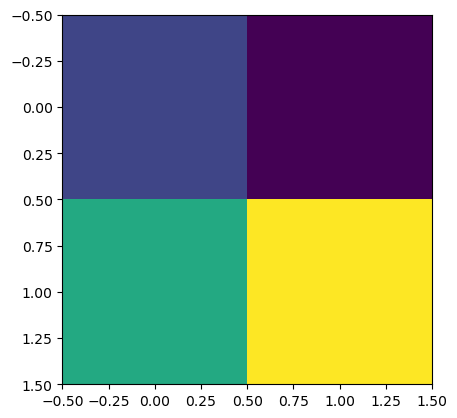

In [10]:
plt.imshow(X[["cdcb_1", "cdcb_2", "cdcb_3", "cdcb_4"]].values.reshape(len(X), 2, 2)[0])

In [60]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dataclasses import dataclass

DEFFAULT_HYPARAM_CONFIG = {
               'objective': 'reg:squarederror',
               'booster': 'gbtree',
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.005,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_depth': 100,
               'max_leaves': 0,
               'min_child_weight': 5,
               'n_estimators': 1_500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.65,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 1
 }


@dataclass
class ExperimentSummary:
    mse_train_loss: float
    mse_test_loss: float
    mae_train_loss: float
    mae_test_loss: float
    model: XGBRegressor



def run_experiment(X: pd.DataFrame,
                   y: pd.DataFrame,
                   booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
                   ) -> ExperimentSummary:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    y_pred_test, y_pred_train = model.predict(X_test), model.predict(X_train)
    train_mse, test_mse = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    train_mae, test_mae = mean_absolute_error(y_train, y_pred_train), mean_absolute_error(y_test, y_pred_test)
        
    
    return ExperimentSummary(
        train_mse,
        test_mse,
        train_mae,
        test_mae,
        model  # just save the last trained model for nwp
    )
        

In [61]:
results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step)
    output = run_experiment(X, y)
    results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


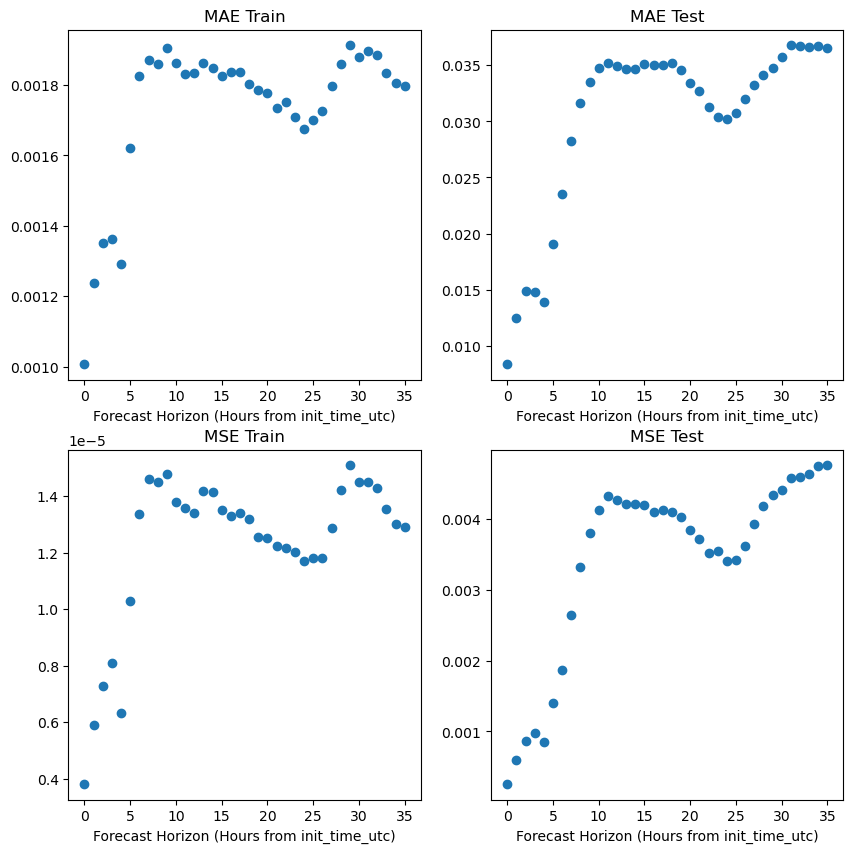

In [65]:
# plot the MAE of the OOS for each model
from typing import Dict

def plot_loss_metrics(results_by_fh: Dict[int, ExperimentSummary]):
    title_mapping = {"MAE Train": lambda x: x.mae_train_loss,
                     "MAE Test": lambda x: x.mae_test_loss,
                     "MSE Train": lambda x: x.mse_train_loss,
                     "MSE Test": lambda x: x.mse_test_loss}
    
    fig, axes = plt.subplots(2,2, figsize=(10, 10))
    
    for idx, title in enumerate(title_mapping.keys()):
        row = int(idx > 1)
        col = idx % 2
        data = pd.Series({step: title_mapping[title](r) for step, r in results.items()})
        axes[row][col].scatter(data.index, data.values)
        axes[row][col].set_title(title)
        axes[row][col].set_xlabel("Forecast Horizon (Hours from init_time_utc)")

plot_loss_metrics(results)

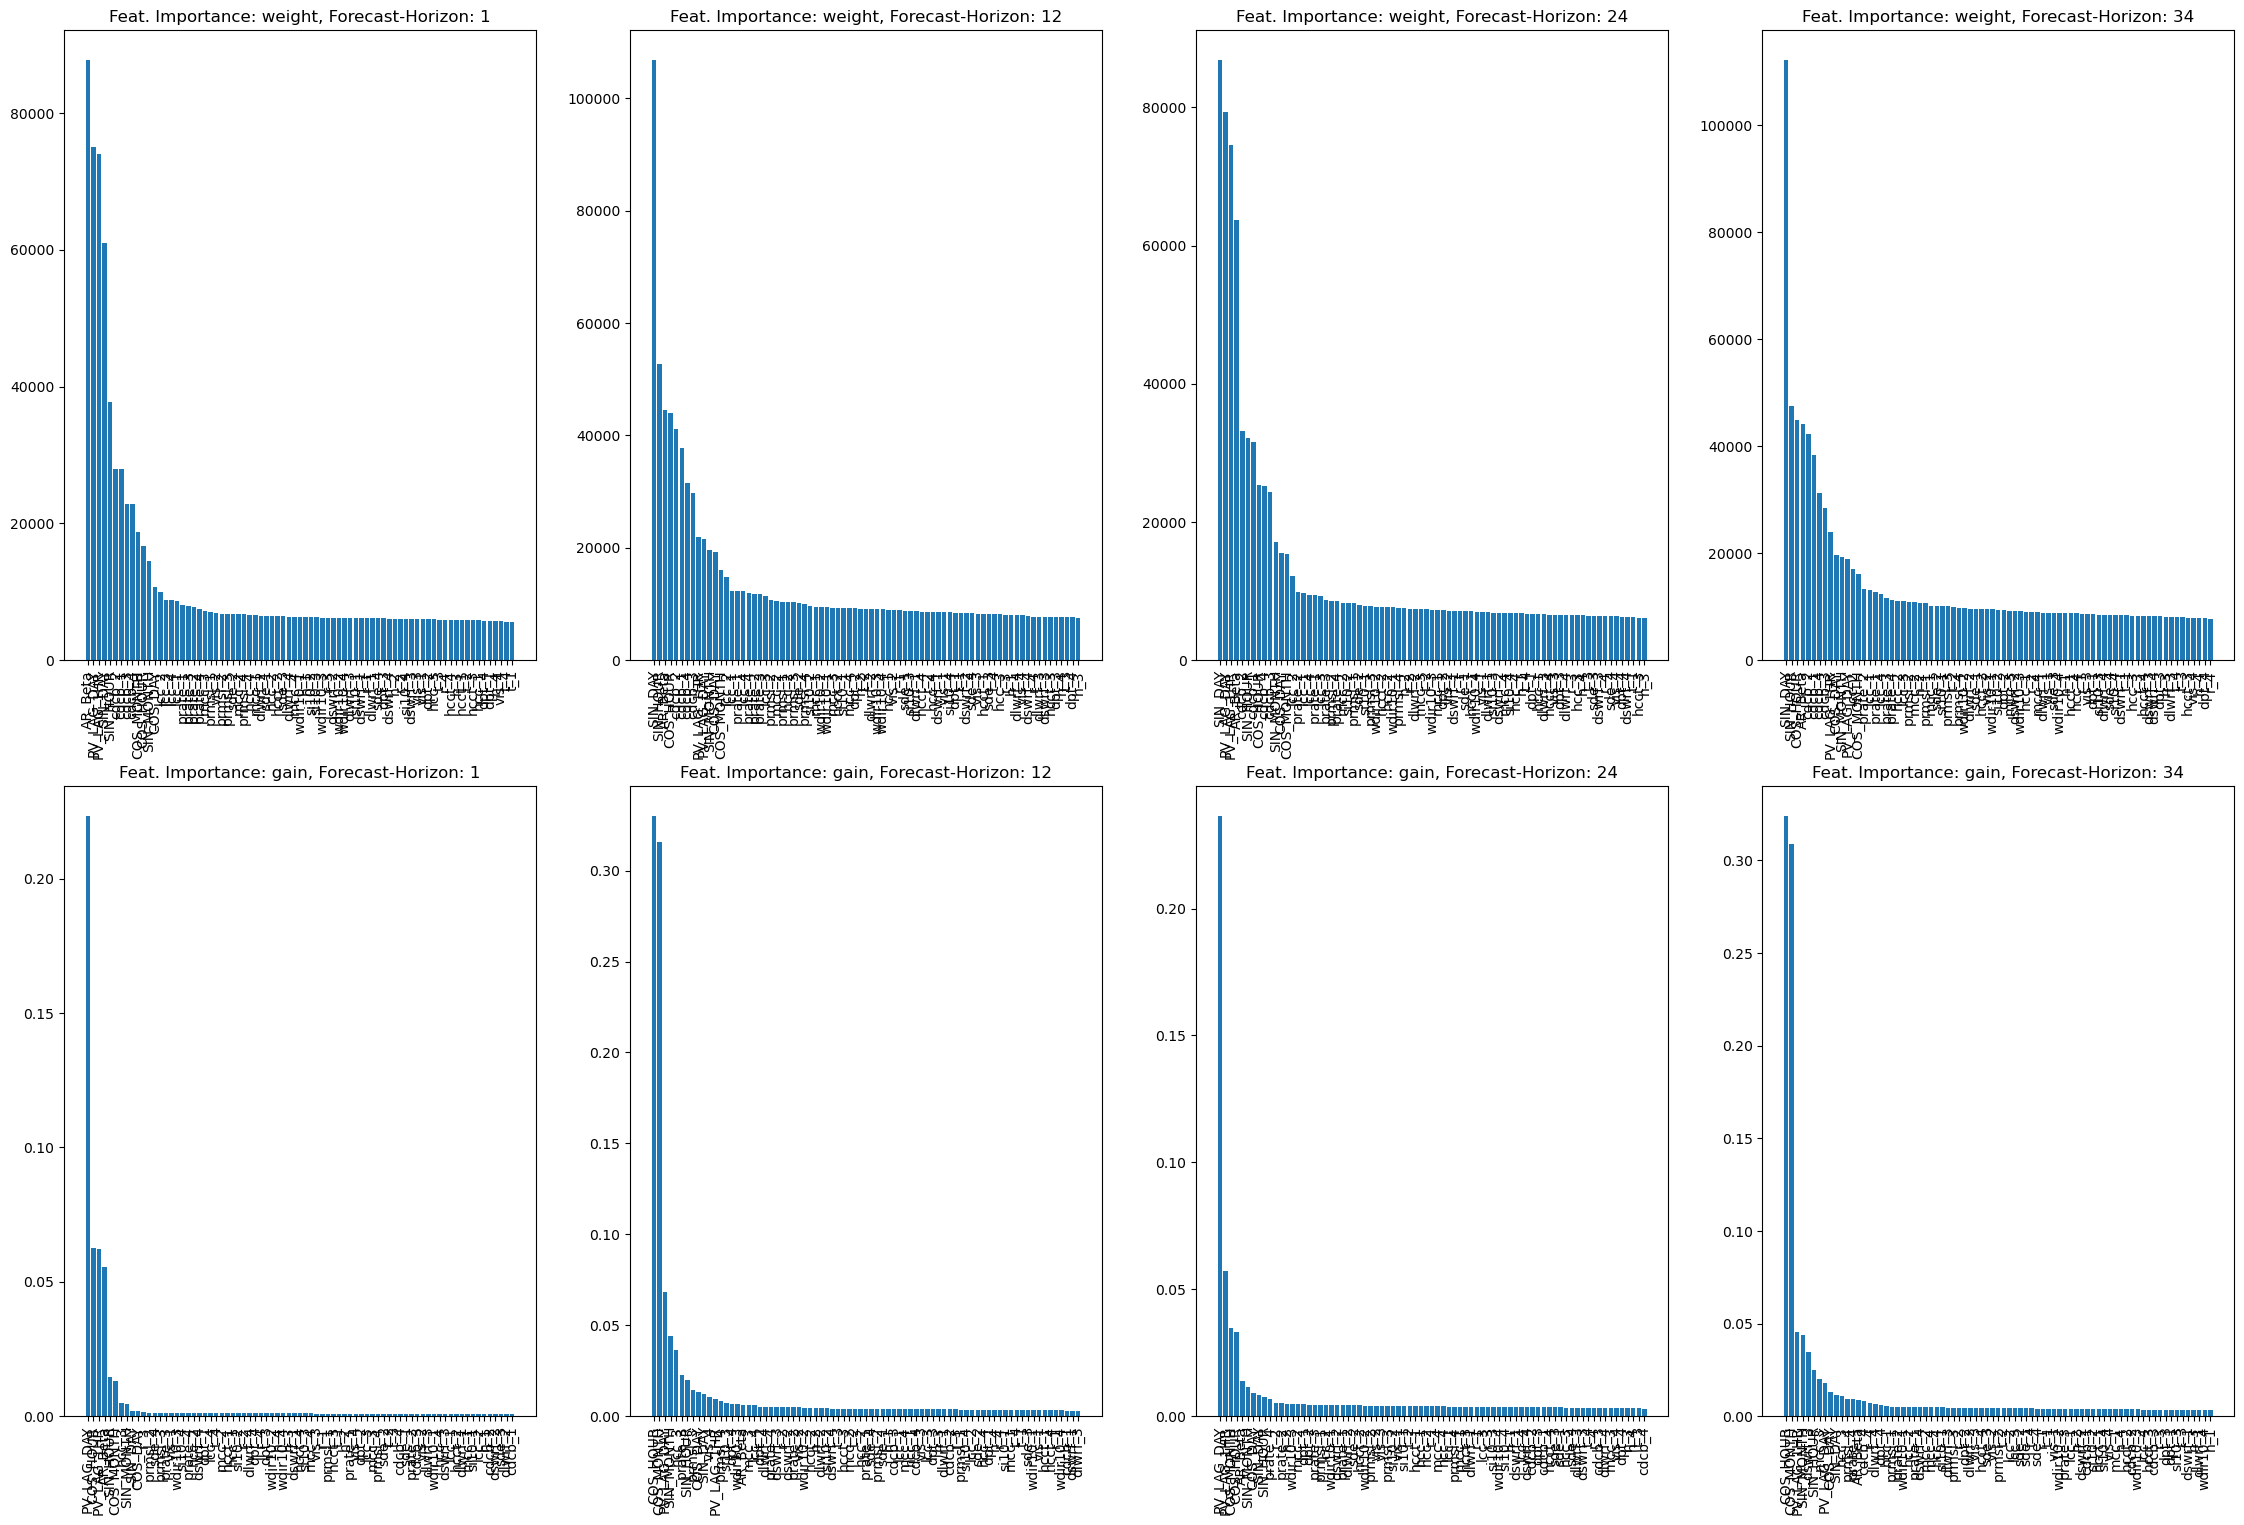

In [66]:
def plot_feature_importances(results_by_fh: Dict[int, ExperimentSummary], forecast_horizons = [1, 12, 24, 34]):
    assert len(forecast_horizons) == 4, "Plotting built for 4 forecast horizons!!"
    fig, axes = plt.subplots(2, 4, figsize=(28, 18))
    
    for param_idx, param in enumerate(["weight", "gain"]):
        for idx, fh in enumerate(forecast_horizons):
            data = pd.DataFrame.from_dict(results_by_fh[fh].model.get_booster().get_score(importance_type=param), orient="index").sort_values(by=0, ascending=False)
            axes[param_idx][idx].bar(range(len(data)), data.values.flatten())#, tick_label=data.index)
            axes[param_idx][idx].set_xticks(range(len(data)))
            axes[param_idx][idx].set_xticklabels(data.index, rotation=90)
            axes[param_idx][idx].set_title(f"Feat. Importance: {param}, Forecast-Horizon: {fh}")
            
        

test = plot_feature_importances(results)


#### Comment:

The performance of the quadrant features is lower than that of the base model with the more granular channel-mean features. It does seem to able to use the NWP data as well for splits, as demonstrated in the feature importance plots. Perhaps if we reduce the number of NWP variables to those highly valued valued by the base model, we may see better generalisation.

In [49]:
# add functionality to drop NWP channels.

def build_datasets_from_local(step: int, variables_of_interest: list[str], nan_to_zero: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame]:
    X = np.load(_get_path_to_quadrant_data(step))
    X = X.reshape(X.shape[2], X.shape[1]*4)
    X =  np.nan_to_num(X) if nan_to_zero else X
    
    
    columns = []
    for var in nwp.coords["variable"].values:
        columns += [f"{var}_{x}" for x in range(1, 5)]
    
    X = pd.DataFrame(data=X, columns = columns, index=evaluation_timeseries)
    X = X.drop([_x for _x in X.columns if _x.split("_")[0] not in variables_of_interest], axis=1)
    y = pd.DataFrame(gsp["generation_mw"] / gsp["installedcapacity_mwp"], index=evaluation_timeseries, columns=["target"])
    
    # shift y by thecdcb_1	cdcb_2	cdcb_3	cdcb_4req = -(shift + np.timedelta64(1, "h")))
    ar_day = y.shift(freq = - (shift + np.timedelta64(1, "D")))
    ar_1.columns = ["PV_LAG_1HR"]
    ar_day.columns = ["PV_LAG_DAY"]
    
    # estimate linear trend of the PV
    window_size = 10
    epsilon = 0.01
    y_covariates = y.shift(freq = -(shift + np.timedelta64(2, "h")))
    y_covariates.columns = ["x"]
    y_target = y.shift(freq = -(shift + np.timedelta64(1, "h")))
    y_target.columns = ["y"]
    data = pd.concat([y_target, y_covariates], axis=1).dropna()
    _x = data["x"].values
    _y = data["y"].values
    _betas = np.nan * np.empty(len(data))
    
    for n in range(window_size, len(data)):
        __y = _y[(n-window_size): n]
        __x = _x[(n-window_size): n]
        __b = max(min((1 / ((__x.T @ __x) + epsilon))  * (__x.T @ __y), 10), -10)
        _betas[n] = __b
    
    betas = pd.DataFrame(data=_betas, columns=["AR_Beta"], index=data.index)
    
    X = pd.concat([X, ar_1, ar_day, betas], axis=1).dropna()
    y = y.loc[X.index]
    
    
    return X, y

In [53]:
FEATURES = ["dswrf", "lcct", "hcct", "t", "wdir10"]

feature_subset_results = dict()

for step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    X, y = build_datasets_from_local(step, FEATURES)
    output = run_experiment(X, y)
    feature_subset_results[step] = output
    print(f"Completed run for step {step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


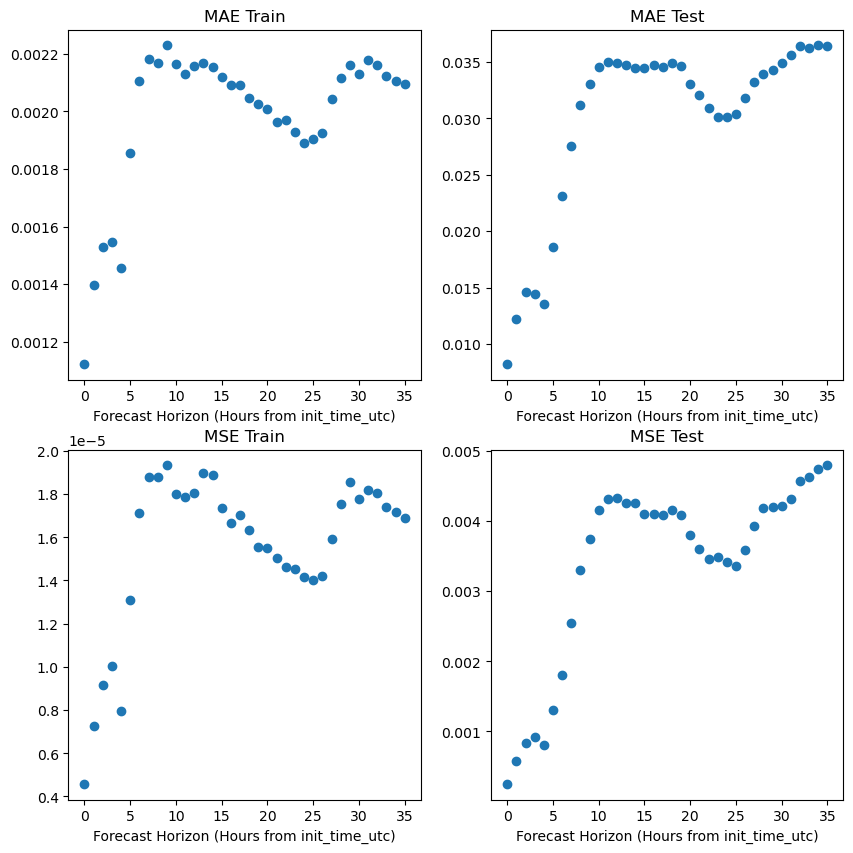

In [55]:
plot_loss_metrics(feature_subset_results)

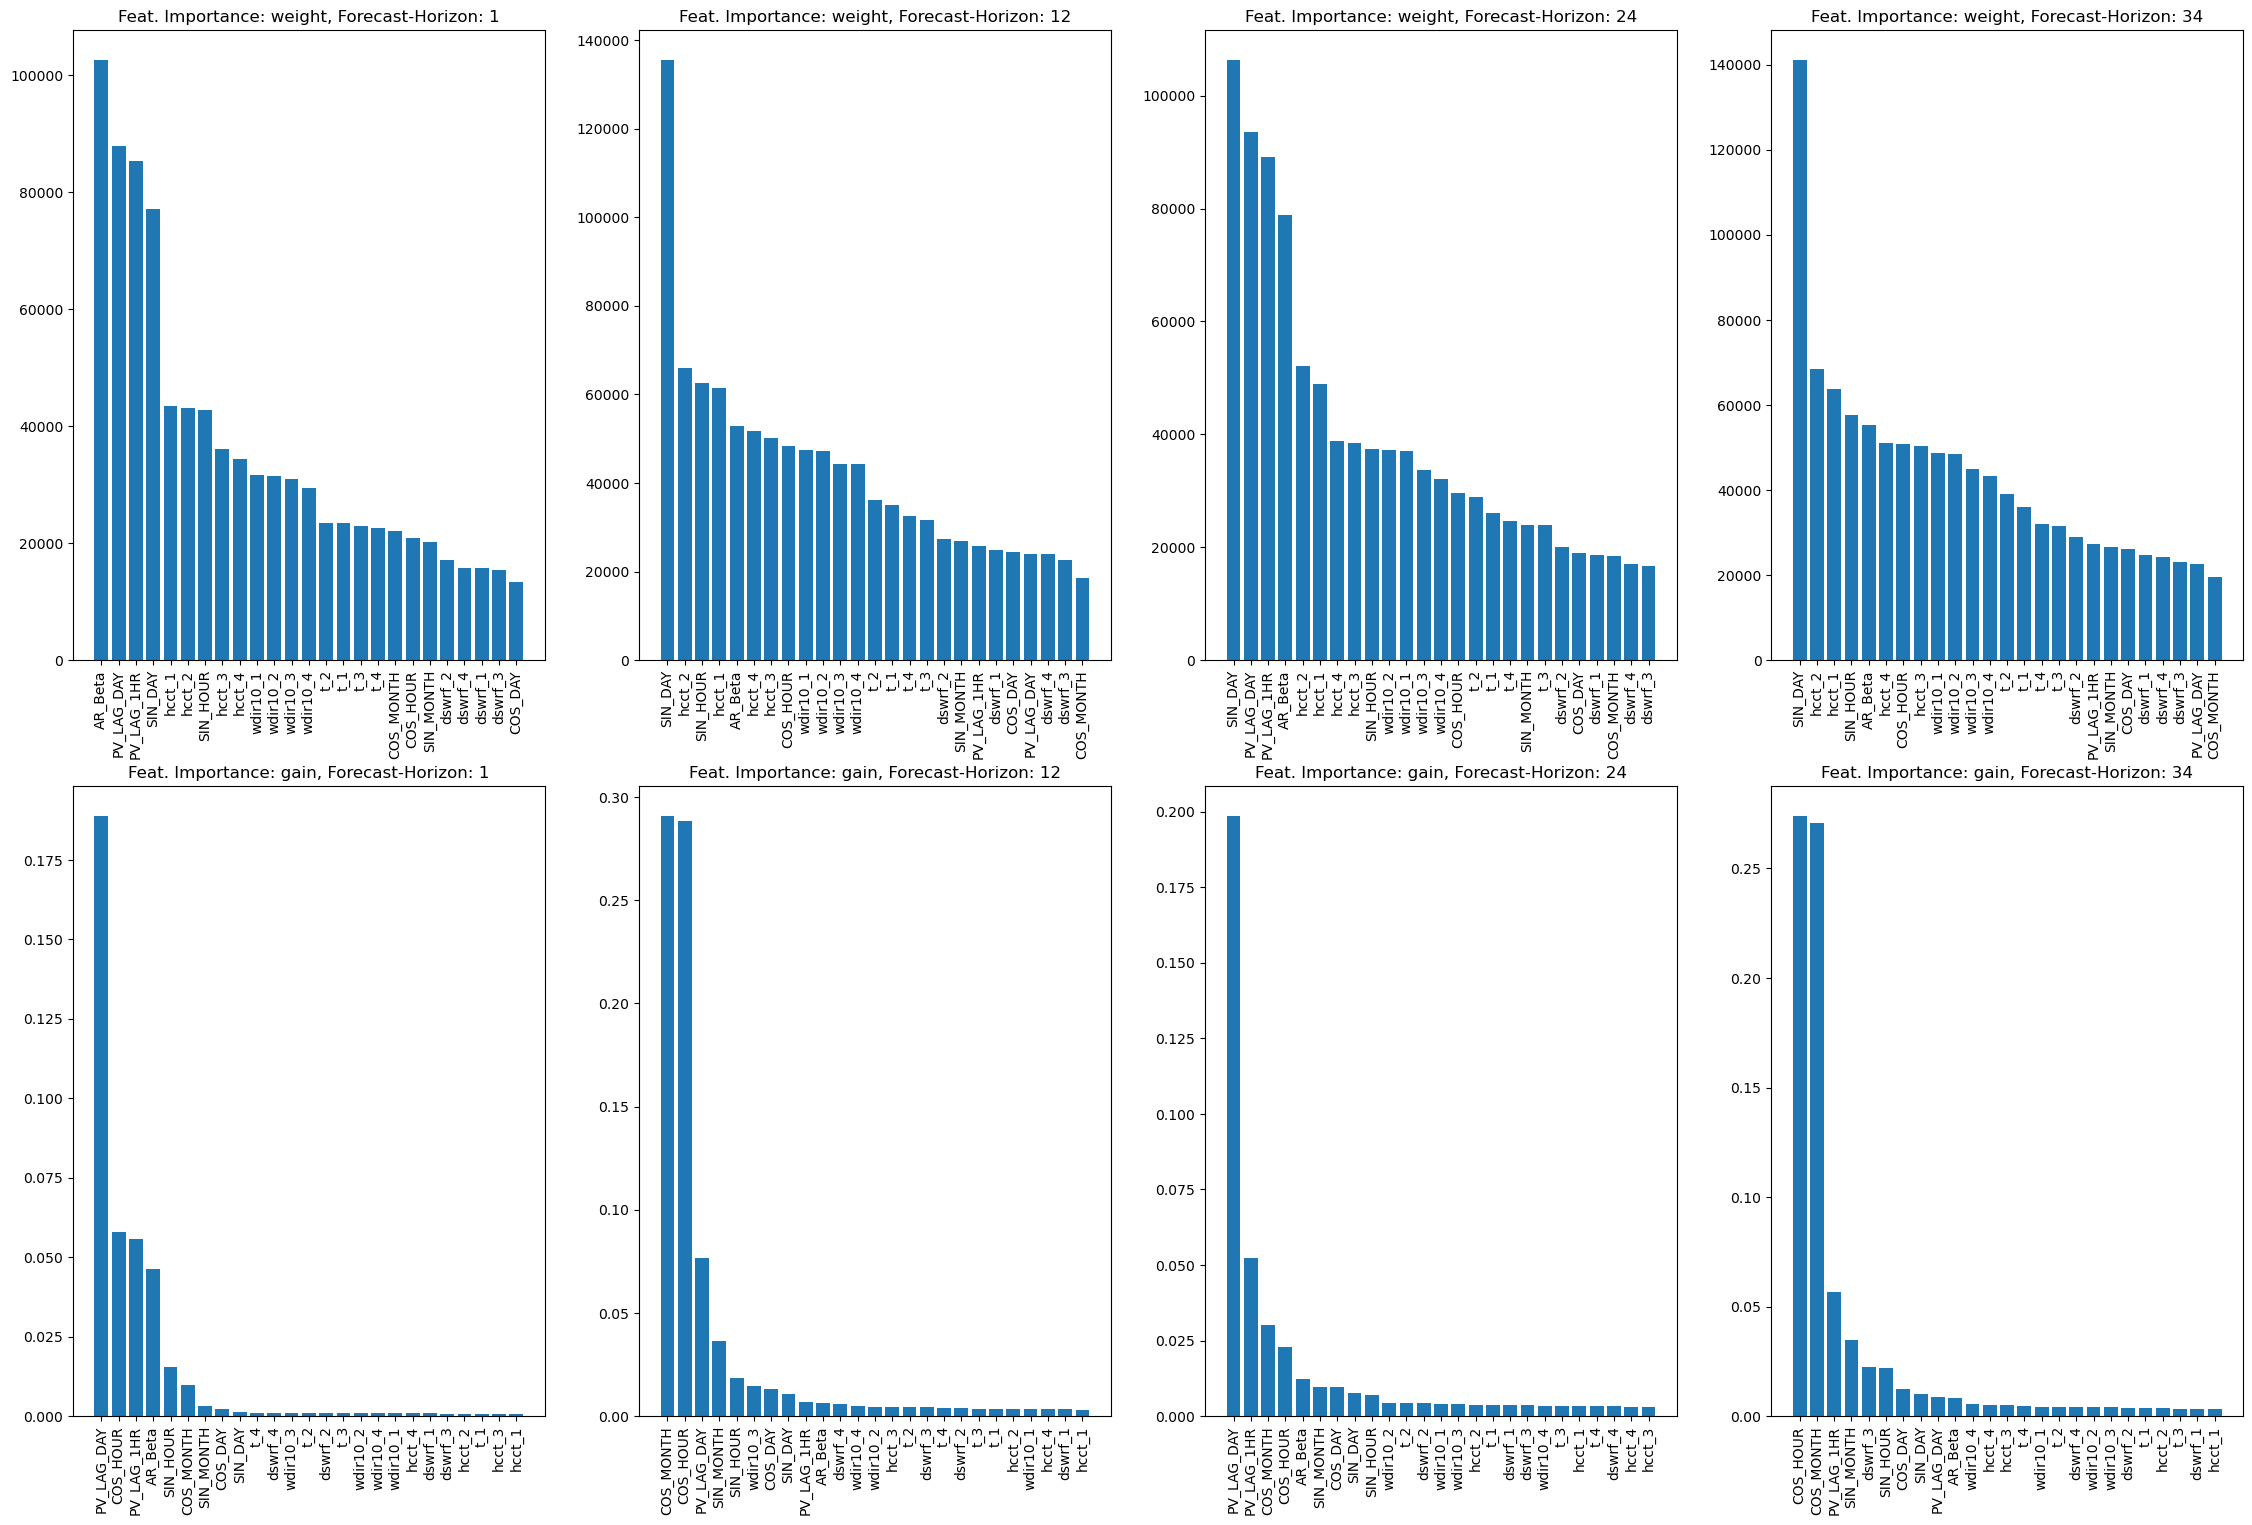

In [56]:
plot_feature_importances(feature_subset_results)

#### Comment:

Still no better generalisation, hold this area for now and instead look at masking the NWP data based on geospatial position relative to the UK (in another notebook). 